# Use Case 7: Trans genetic effects

We will explore [trans genetic effects](https://en.wikipedia.org/wiki/Trans-acting). This occurs when DNA mutation in one gene has an effect on a different gene. To fully understand the effect of DNA mutation, this use case will show how to find some of those downstream affected protiens using two prominent cancer genes: TP53 and ARID1A.

# Part I: TP53

TP53 is a tumor suppressing gene that is very important in helping prevent mutation, as well as repairing damaged DNA in cells [(Wikipedia)](https://en.wikipedia.org/wiki/P53). Since TP53 has a well-documented set of interating proteins, we'll examine those to find trans effects.

# Step 1: Import Libraries

Here we will import standard python libraries used to analyze and visualize data as pandas dataframes, as well as our CPTAC data.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

import cptac
import cptac.utils as ut

en = cptac.Endometrial()

Our analysis here will be done with endometrial cancer, but can also be done using any of the other cancers in the CPTAC dataset.

# Step 2: Get Interacting Proteins

Now we will get a list of the proteins that are know to interact with TP53 directly. Our list comes from Bioplex, a process that identifies proteins in direct physical contact. The CPTAC package also has a method called get_interacting_proteins_bioplex, which returns a list of proteins that interact with our gene in this way.

In [2]:
gene = "TP53"
omics = "proteomics"

interacting_proteins = ut.get_interacting_proteins_bioplex(gene)

print("Interacting Proteins:")
print(interacting_proteins)

Interacting Proteins:
['CUL7', 'MDM4', 'AURKA', 'CUL9', 'HOMER3', 'HNF4A', 'FAM111A', 'FAM175B', 'RORC', 'GPR156', 'CELA2B', 'FBXW7', 'MDM2']


# Step 3: Get Omics Data

Now we create a new dataframe containing protein measurements for TP53 and its interacting proteins, calling en.join_omics_to_mutations. We note thqta if proteomfics data does not identify one of the genes in your request, the join method will throw a warning and fill with NAN (a missing value).

In [3]:
protdf = en.join_omics_to_mutations(mutations_genes=gene, omics_df_name=omics, omics_genes=interacting_proteins)
protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']

In [4]:
protdf.head()

Name,CUL7_proteomics,MDM4_proteomics,AURKA_proteomics,CUL9_proteomics,HOMER3_proteomics,HNF4A_proteomics,FAM111A_proteomics,FAM175B_proteomics,RORC_proteomics,GPR156_proteomics,CELA2B_proteomics,FBXW7_proteomics,MDM2_proteomics,TP53_Mutation,TP53_Location,TP53_Mutation_Status,Sample_Status
Sample_ID,,,,,,,,,,,,,,,,,
S001,0.0408,NaN,NaN,0.0355,-0.443,NaN,0.363000,NaN,NaN,NaN,NaN,NaN,NaN,[Missense_Mutation],[p.R248W],Single_mutation,Tumor
S002,-0.1430,NaN,0.311,0.1480,-0.897,NaN,0.601000,NaN,NaN,NaN,NaN,NaN,NaN,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor
S003,0.0999,NaN,NaN,0.1130,-0.451,NaN,-0.280000,NaN,NaN,NaN,NaN,NaN,NaN,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor
S005,-0.7460,NaN,-0.798,0.1680,-0.034,NaN,0.066500,NaN,NaN,NaN,NaN,NaN,NaN,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor
S006,-0.1200,NaN,3.110,-0.2530,-0.535,NaN,-0.000411,NaN,NaN,NaN,NaN,NaN,NaN,[Missense_Mutation],[p.S241C],Single_mutation,Tumor


If you scroll the table abo ve all the way over to the right, you will see three columns for TP53 mutation. As a sample may have a complete set of mutations, these columns contain lists and the "Mutation_status" column says whether it is a single or multiple mutation. We want to simplify this column to have just two values, either "Mutated" or "Wildtype." Next, we remove a few unwanted columns.

In [5]:
for ind, row in protdf.iterrows():
    if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
        protdf.at[ind,'TP53 Mutation Status'] = 'Mutated'
    else:
        protdf.at[ind,'TP53 Mutation Status'] = 'Wildtype'

In [6]:
protdf = protdf.drop(gene+"_Mutation",axis=1)
protdf = protdf.drop(gene+"_Location",axis=1)
protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
protdf = protdf.drop("Sample_Status",axis=1)

# Step 4: Do T-tests

We take the column names, which are the interacting proteins, and create a list in order to run our t-tests for each protein individually.

In [7]:
col_list = list(protdf.columns)
col_list.remove('TP53 Mutation Status')

In [8]:
print(col_list)

['CUL7_proteomics', 'MDM4_proteomics', 'AURKA_proteomics', 'CUL9_proteomics', 'HOMER3_proteomics', 'HNF4A_proteomics', 'FAM111A_proteomics', 'FAM175B_proteomics', 'RORC_proteomics', 'GPR156_proteomics', 'CELA2B_proteomics', 'FBXW7_proteomics', 'MDM2_proteomics']


Now we call wrap_ttest, which is an accessory function in cptac.utils. It expects one column with a binary variable (this is why we crearted the 'TP53 Mutation Status' column earlier), and all other data as numeric. It will then run ttests on each column to determine if there is a statistically significant difference between the binary values. For us, it will identify if there are significantly different protein abundances between wildtype and mutated samples.

In [9]:
print("Doing t-test comparisons\n")
wrap_results = ut.wrap_ttest(protdf, 'TP53 Mutation Status', col_list)
#This gives us back a dataframe with significant comparisons

if wrap_results is not None:
        print(wrap_results)
        print("\n\n")

Doing t-test comparisons

1 significant comparisons!
         Comparison   P_Value
0  AURKA_proteomics  0.000016





Our t-test returned one protein whose levels were significantly changed by a mutation in TP53, Aurora Kinase, which has a known relationship with TP53 [(link)](https://www.ncbi.nlm.nih.gov/pubmed/27933271). Let's lot the data with Seaborn to show exactly how levels of aurora kinase change with our gene's mutation.

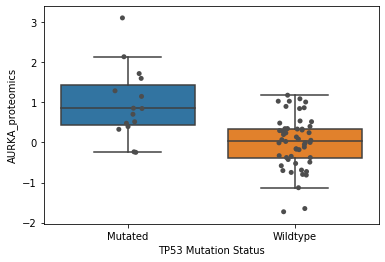

In [10]:
sns.boxplot(data = protdf, x = 'TP53 Mutation Status', y = 'AURKA_proteomics', showfliers = False)
sns.stripplot(data = protdf, x = 'TP53 Mutation Status', y = 'AURKA_proteomics', jitter = True, dodge = True, color = '.3')

From this boxplot, we can see that there is a significant increase in aurora kinase levels with a mutation in TP53.

# Part II: Example Using ARID1A

We will now look at ARID1A, which potentially affects the transcription of many genes through its function as a chromatin remodeling protein [(Wikipedia)](https://en.wikipedia.org/wiki/ARID1A).

In order to perform this analysis, we will use the same steps as we did earlier, only this time without separated code blocks. Because we are not sure which proteins might be affected, we will look for trans effects in all the proteomics data. Due to the high amount of comparisons, this will take a little bit of time. In the end, we will have a list of genes affected by ARID1A.

In [11]:
gene = "ARID1A"
print("\nGene: ", gene)

# Step 1: Create dataframe in order to do comparisons with wrap_ttest
protdf = en.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=omics)
protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']

for ind, row in protdf.iterrows():
    if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
        protdf.at[ind,'ARID1A Mutation Status'] = 'Mutated'
    else:
        protdf.at[ind,'ARID1A Mutation Status'] = 'Wildtype'

        
# Step 2: Format the dataframe to set it up properly for our t-test
protdf = protdf.drop(gene+"_Mutation",axis=1)
protdf = protdf.drop(gene+"_Location",axis=1)
protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
protdf = protdf.drop("Sample_Status",axis=1)


#Step 3: Make list of columns to be compared using t-tests
col_list = list(protdf.columns)
col_list.remove('ARID1A Mutation Status')

    
#Step 4: Call wrap_ttest, pass in formatted dataframe, print results
print("Doing t-test comparisons\n")
wrap_results = ut.wrap_ttest(protdf, 'ARID1A Mutation Status', col_list)

if wrap_results is not None:
        print(wrap_results)
        print("\n\n")


Gene:  ARID1A


Doing t-test comparisons



/Users/kimball.benjamin1/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/kimball.benjamin1/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


8 significant comparisons!
          Comparison       P_Value
0  ARID1A_proteomics  1.025018e-10
1   MAP1S_proteomics  1.010149e-07
2    DPF2_proteomics  2.166609e-07
3   KDM4B_proteomics  4.414547e-07
4    RRM1_proteomics  4.455870e-07
5  MAP7D3_proteomics  4.880890e-07
6   CYTH3_proteomics  3.109396e-06
7   CEP78_proteomics  3.749172e-06





Each of the proteins shown can be individually analyzed in the same manner that we showed above. The reason for the relatively small list of proteins shown here is that our wrap_ttest does Bonferroni correction, so the cutoff for "significance" is very strict. For further ideas about how to analyze larger lists of genes, refer to usecase 5.